In [1]:
import argparse
import os
from ast import arg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN

from matplotlib import pyplot as plt
import numpy as np

In [2]:
class VRLoss(nn.Module):

    def __init__(self, w_cos1 = 1., w_cos2 = 1., w_l2 = 2.) -> None:
        super().__init__()
        self.cosinesim1 = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.cosinesim2 = nn.CosineSimilarity(dim=2, eps=1e-6)
        self.l2 = nn.MSELoss()
        s = w_cos1 + w_cos2 + w_l2
        self.w_cos1, self.w_cos2, self.w_l2 = w_cos1/s, w_cos2/s, w_l2/s

    def forward(self, output:torch.Tensor, target:torch.Tensor):
        b, n, _ = output.shape
        sim1 = -self.cosinesim1(output, target)
        sim2 = -self.cosinesim2(output, target)
        l2 = self.l2(output, target)

        l = self.w_cos1*(sim1.exp().mean()-1e-1) + self.w_cos2*(sim2.exp().mean()-1e-1) + self.w_l2*l2
        
        return l

In [3]:
dataset = EncoderDecoderStaticDataset('/home/shivam/DKLabs/OilGasProject/WellLogCorrelation/data')
dataloader = DataLoader(dataset, batch_size = 10, shuffle = True, num_workers = 4)
data_len = len(dataloader)
log_n = int(data_len//2)

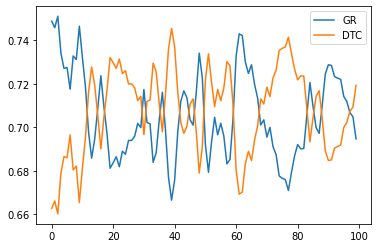

In [4]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = EncoderDecoder1DCNN(2, 50)
model.to(device)
model.load_state_dict(torch.load('./modelstate_vr_loss_l2_dominated'))
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

In [8]:
criterion =  VRLoss() # Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.0007, weight_decay=0.0001)

In [9]:
def compute_loss(dl, model, crt):
    total_loss = 0.
    cnt = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dl:
            data = data.to(device)
            
            # calculate outputs by running images through the network
            output = model(data)

            loss = crt(output, data)
            
            # print(predicted, labels)
            total_loss += loss.item()*data.size(0)
            cnt += data.size(0)
    return total_loss/cnt

In [10]:
rll = []
total_loss = []

In [11]:
model.train()
for epoch in range(500):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data = data.to(device) # Move data to target device

        # zero the parameter gradients
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss/log_n}')
            running_loss = 0
    total_loss += [compute_loss(dataloader, model, criterion)]
    print(f'Total loss : {total_loss[-1]}')

Epoch : 0, Iteration : 4,Running loss : 0.6258838891983032
Epoch : 0, Iteration : 9,Running loss : 0.4044062256813049
Total loss : 0.32152881670971306
Epoch : 1, Iteration : 4,Running loss : 0.2813590705394745
Epoch : 1, Iteration : 9,Running loss : 0.20330673158168794
Total loss : 0.1889781793769525
Epoch : 2, Iteration : 4,Running loss : 0.17619041502475738
Epoch : 2, Iteration : 9,Running loss : 0.15176516473293306
Total loss : 0.15510618473802293
Epoch : 3, Iteration : 4,Running loss : 0.1508655846118927
Epoch : 3, Iteration : 9,Running loss : 0.1532795786857605
Total loss : 0.15239576934551707
Epoch : 4, Iteration : 4,Running loss : 0.15374828577041627
Epoch : 4, Iteration : 9,Running loss : 0.17982430756092072
Total loss : 0.15639468328076966
Epoch : 5, Iteration : 4,Running loss : 0.15326995253562928
Epoch : 5, Iteration : 9,Running loss : 0.14254522919654847
Total loss : 0.15033239095794912
Epoch : 6, Iteration : 4,Running loss : 0.1532004177570343
Epoch : 6, Iteration : 9,Runn

Epoch : 53, Iteration : 9,Running loss : 0.13760091364383698
Total loss : 0.13960093898432596
Epoch : 54, Iteration : 4,Running loss : 0.14035760760307311
Epoch : 54, Iteration : 9,Running loss : 0.1367696076631546
Total loss : 0.1406183197182052
Epoch : 55, Iteration : 4,Running loss : 0.1366666853427887
Epoch : 55, Iteration : 9,Running loss : 0.14046186506748198
Total loss : 0.14025153432573592
Epoch : 56, Iteration : 4,Running loss : 0.14341346323490142
Epoch : 56, Iteration : 9,Running loss : 0.14230993688106536
Total loss : 0.14047043846578014
Epoch : 57, Iteration : 4,Running loss : 0.14027708768844604
Epoch : 57, Iteration : 9,Running loss : 0.1405647337436676
Total loss : 0.14106526332242147
Epoch : 58, Iteration : 4,Running loss : 0.13804393708705903
Epoch : 58, Iteration : 9,Running loss : 0.14108485579490662
Total loss : 0.1408076675570741
Epoch : 59, Iteration : 4,Running loss : 0.14079013466835022
Epoch : 59, Iteration : 9,Running loss : 0.13952297568321229
Total loss : 0

Total loss : 0.1389731852983942
Epoch : 107, Iteration : 4,Running loss : 0.1413274496793747
Epoch : 107, Iteration : 9,Running loss : 0.13815374970436095
Total loss : 0.141267328542106
Epoch : 108, Iteration : 4,Running loss : 0.14070284366607666
Epoch : 108, Iteration : 9,Running loss : 0.141917622089386
Total loss : 0.14066059644124945
Epoch : 109, Iteration : 4,Running loss : 0.13914379179477693
Epoch : 109, Iteration : 9,Running loss : 0.14496863782405853
Total loss : 0.14079460592902437
Epoch : 110, Iteration : 4,Running loss : 0.14340123832225798
Epoch : 110, Iteration : 9,Running loss : 0.13949114084243774
Total loss : 0.14089128709569268
Epoch : 111, Iteration : 4,Running loss : 0.1399070143699646
Epoch : 111, Iteration : 9,Running loss : 0.14163414537906646
Total loss : 0.13863909274947886
Epoch : 112, Iteration : 4,Running loss : 0.1415627419948578
Epoch : 112, Iteration : 9,Running loss : 0.1381838798522949
Total loss : 0.14013147506178641
Epoch : 113, Iteration : 4,Running

Epoch : 159, Iteration : 9,Running loss : 0.13757133781909942
Total loss : 0.14047663248315148
Epoch : 160, Iteration : 4,Running loss : 0.13818348348140716
Epoch : 160, Iteration : 9,Running loss : 0.1408962845802307
Total loss : 0.13810737370228282
Epoch : 161, Iteration : 4,Running loss : 0.14318684339523316
Epoch : 161, Iteration : 9,Running loss : 0.13999506533145906
Total loss : 0.13916174246340382
Epoch : 162, Iteration : 4,Running loss : 0.1386578381061554
Epoch : 162, Iteration : 9,Running loss : 0.1366258442401886
Total loss : 0.14045171865395137
Epoch : 163, Iteration : 4,Running loss : 0.14243447482585908
Epoch : 163, Iteration : 9,Running loss : 0.1383274018764496
Total loss : 0.13996784845177007
Epoch : 164, Iteration : 4,Running loss : 0.13824965059757233
Epoch : 164, Iteration : 9,Running loss : 0.1348413497209549
Total loss : 0.14017218625058933
Epoch : 165, Iteration : 4,Running loss : 0.13480371236801147
Epoch : 165, Iteration : 9,Running loss : 0.1431176096200943
To

Epoch : 212, Iteration : 4,Running loss : 0.14004283845424653
Epoch : 212, Iteration : 9,Running loss : 0.13814516067504884
Total loss : 0.13825321319151898
Epoch : 213, Iteration : 4,Running loss : 0.14280363619327546
Epoch : 213, Iteration : 9,Running loss : 0.1387035518884659
Total loss : 0.13788352693830216
Epoch : 214, Iteration : 4,Running loss : 0.13608831763267518
Epoch : 214, Iteration : 9,Running loss : 0.13995351791381835
Total loss : 0.1372472555661688
Epoch : 215, Iteration : 4,Running loss : 0.13980868458747864
Epoch : 215, Iteration : 9,Running loss : 0.13777049481868744
Total loss : 0.1401948621686624
Epoch : 216, Iteration : 4,Running loss : 0.14279572665691376
Epoch : 216, Iteration : 9,Running loss : 0.13772344589233398
Total loss : 0.13952780712623986
Epoch : 217, Iteration : 4,Running loss : 0.13807129263877868
Epoch : 217, Iteration : 9,Running loss : 0.14140041172504425
Total loss : 0.13807424720452757
Epoch : 218, Iteration : 4,Running loss : 0.13643346428871156

Total loss : 0.1386067359423151
Epoch : 265, Iteration : 4,Running loss : 0.14090114831924438
Epoch : 265, Iteration : 9,Running loss : 0.13978553414344788
Total loss : 0.1378654603447233
Epoch : 266, Iteration : 4,Running loss : 0.14144310355186462
Epoch : 266, Iteration : 9,Running loss : 0.14181456267833709
Total loss : 0.1360568893807275
Epoch : 267, Iteration : 4,Running loss : 0.13484289050102233
Epoch : 267, Iteration : 9,Running loss : 0.1395799309015274
Total loss : 0.14021872014415507
Epoch : 268, Iteration : 4,Running loss : 0.1411150723695755
Epoch : 268, Iteration : 9,Running loss : 0.1362583875656128
Total loss : 0.1372531168923086
Epoch : 269, Iteration : 4,Running loss : 0.14077657461166382
Epoch : 269, Iteration : 9,Running loss : 0.13799131512641907
Total loss : 0.1424976283190202
Epoch : 270, Iteration : 4,Running loss : 0.13772588968276978
Epoch : 270, Iteration : 9,Running loss : 0.14339060485363006
Total loss : 0.13933573024613516
Epoch : 271, Iteration : 4,Runnin

Epoch : 317, Iteration : 9,Running loss : 0.14146972000598906
Total loss : 0.1367468207466359
Epoch : 318, Iteration : 4,Running loss : 0.14264231026172638
Epoch : 318, Iteration : 9,Running loss : 0.1377578556537628
Total loss : 0.13774400584551752
Epoch : 319, Iteration : 4,Running loss : 0.1375432074069977
Epoch : 319, Iteration : 9,Running loss : 0.13462163209915162
Total loss : 0.1392600311308491
Epoch : 320, Iteration : 4,Running loss : 0.13454176485538483
Epoch : 320, Iteration : 9,Running loss : 0.14066622257232667
Total loss : 0.13839962622340846
Epoch : 321, Iteration : 4,Running loss : 0.14066068828105927
Epoch : 321, Iteration : 9,Running loss : 0.13760695457458497
Total loss : 0.13855201674967396
Epoch : 322, Iteration : 4,Running loss : 0.14075180590152742
Epoch : 322, Iteration : 9,Running loss : 0.1378755897283554
Total loss : 0.14006528075860472
Epoch : 323, Iteration : 4,Running loss : 0.13768191933631896
Epoch : 323, Iteration : 9,Running loss : 0.13940519988536834
T

Epoch : 370, Iteration : 9,Running loss : 0.1447695940732956
Total loss : 0.13672218426149718
Epoch : 371, Iteration : 4,Running loss : 0.13740599453449248
Epoch : 371, Iteration : 9,Running loss : 0.14071832001209258
Total loss : 0.1417038732645463
Epoch : 372, Iteration : 4,Running loss : 0.13751285672187805
Epoch : 372, Iteration : 9,Running loss : 0.1393801212310791
Total loss : 0.1400075332850826
Epoch : 373, Iteration : 4,Running loss : 0.1375583976507187
Epoch : 373, Iteration : 9,Running loss : 0.1394125998020172
Total loss : 0.13912128793949985
Epoch : 374, Iteration : 4,Running loss : 0.13594716489315034
Epoch : 374, Iteration : 9,Running loss : 0.140658837556839
Total loss : 0.14007144436544303
Epoch : 375, Iteration : 4,Running loss : 0.14063144624233245
Epoch : 375, Iteration : 9,Running loss : 0.1384920597076416
Total loss : 0.13763669650165403
Epoch : 376, Iteration : 4,Running loss : 0.1394003599882126
Epoch : 376, Iteration : 9,Running loss : 0.14060784578323365
Total 

Epoch : 423, Iteration : 4,Running loss : 0.13600655198097228
Epoch : 423, Iteration : 9,Running loss : 0.13586050271987915
Total loss : 0.13829183061512149
Epoch : 424, Iteration : 4,Running loss : 0.1407411962747574
Epoch : 424, Iteration : 9,Running loss : 0.1395474463701248
Total loss : 0.13763106355861743
Epoch : 425, Iteration : 4,Running loss : 0.1374429941177368
Epoch : 425, Iteration : 9,Running loss : 0.13628851771354675
Total loss : 0.13675042621943415
Epoch : 426, Iteration : 4,Running loss : 0.13576538264751434
Epoch : 426, Iteration : 9,Running loss : 0.13743953108787538
Total loss : 0.13916926572517474
Epoch : 427, Iteration : 4,Running loss : 0.13588108122348785
Epoch : 427, Iteration : 9,Running loss : 0.13787438571453095
Total loss : 0.13901332172812247
Epoch : 428, Iteration : 4,Running loss : 0.13747144639492034
Epoch : 428, Iteration : 9,Running loss : 0.14278399646282197
Total loss : 0.13922817214411132
Epoch : 429, Iteration : 4,Running loss : 0.1375120222568512


Total loss : 0.13988076789038523
Epoch : 476, Iteration : 4,Running loss : 0.13588032126426697
Epoch : 476, Iteration : 9,Running loss : 0.13894067704677582
Total loss : 0.1383160012108939
Epoch : 477, Iteration : 4,Running loss : 0.13735956251621245
Epoch : 477, Iteration : 9,Running loss : 0.13909433484077455
Total loss : 0.13835477372821497
Epoch : 478, Iteration : 4,Running loss : 0.13730596303939818
Epoch : 478, Iteration : 9,Running loss : 0.13742091059684752
Total loss : 0.13845358728146068
Epoch : 479, Iteration : 4,Running loss : 0.13733267784118652
Epoch : 479, Iteration : 9,Running loss : 0.13946947157382966
Total loss : 0.13828447157022905
Epoch : 480, Iteration : 4,Running loss : 0.1404977798461914
Epoch : 480, Iteration : 9,Running loss : 0.13751067817211152
Total loss : 0.13833974362636098
Epoch : 481, Iteration : 4,Running loss : 0.14049152433872222
Epoch : 481, Iteration : 9,Running loss : 0.13647745549678802
Total loss : 0.1388735996217144
Epoch : 482, Iteration : 4,R

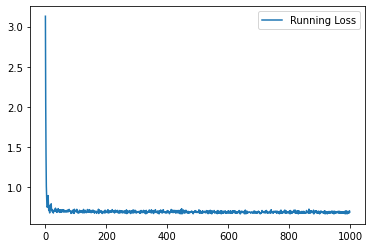

In [12]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.legend()
plt.show()

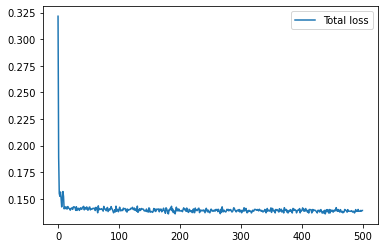

In [13]:
plt.plot(total_loss, label='Total loss')
plt.legend()
plt.show()

In [28]:
torch.save(model.state_dict(), './modelstate_vr_loss_l2_dominated')

In [34]:
model = EncoderDecoder1DCNN(2, 50)
model.to(device)
model.load_state_dict(torch.load('./modelstate_l2_norm'))
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

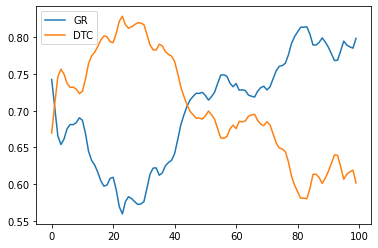

In [35]:
sample_data = dataset.__getitem__(1)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [36]:
sample_data_ = sample_data.unsqueeze(dim=0).to(device)
reconst_data = model(sample_data_)
reconst_data = reconst_data.detach().cpu().squeeze(dim=0).numpy()

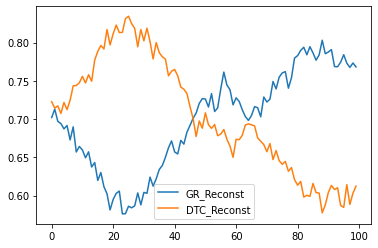

In [37]:
plt.plot(reconst_data[0, :], label='GR_Reconst')
plt.plot(reconst_data[1, :], label='DTC_Reconst')
plt.legend()
plt.show()

In [27]:
reconst_data

array([[0.69381624, 0.72355396, 0.7182385 , 0.7468714 , 0.74802154,
        0.7814969 , 0.80479103, 0.7721964 , 0.78980696, 0.8018797 ,
        0.85426724, 0.86842835, 0.8601514 , 0.82700586, 0.80794924,
        0.8045227 , 0.78609717, 0.75091964, 0.72588664, 0.655561  ,
        0.6836588 , 0.6727422 , 0.66252893, 0.6817747 , 0.7196803 ,
        0.72912824, 0.7637628 , 0.76019865, 0.7627757 , 0.7455267 ,
        0.7188705 , 0.732229  , 0.72165495, 0.7302908 , 0.7390727 ,
        0.7358597 , 0.72973806, 0.7454727 , 0.7057282 , 0.669145  ,
        0.65915465, 0.6140305 , 0.6098071 , 0.56824625, 0.5630645 ,
        0.51292443, 0.5599715 , 0.5563968 , 0.52622294, 0.5629573 ,
        0.56769514, 0.58988655, 0.5982224 , 0.65177304, 0.6521034 ,
        0.62349725, 0.710823  , 0.73753315, 0.76130533, 0.7685658 ,
        0.81542903, 0.83288145, 0.85223126, 0.8642555 , 0.7992891 ,
        0.792726  , 0.7536891 , 0.6973183 , 0.62994105, 0.5665115 ,
        0.53713024, 0.47117382, 0.47904268, 0.45